# Using image segmentation and computer vision to diagnose SRP problems

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import os
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path  
from tqdm import tqdm  
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [8]:
DATA_DIR = Path('E:/Work/PHOTOS')
BATCH_SIZE = 32
IMAGE_SIZE = 224
TEST_SIZE= 0.2
NUM_WORKERS = 0

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label


In [9]:
def load_data(data_dir: Path, batch_size, image_size, test_size, num_workers): 
    image_paths = []
    labels = []
    class_names = []
    class_to_idx = {}

    # استخراج الصور من المجلدات المصنفة وتصنيفها
    for i, class_path in enumerate(data_dir.iterdir()): 
        if class_path.is_dir(): 
            class_name = class_path.name  
            class_names.append(class_name)
            class_to_idx[class_name] = i
            for img_path in class_path.iterdir():  
                if img_path.is_file():
                   image_paths.append(str(img_path))
                   labels.append(i)

    
    train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_size, random_state=42, stratify=labels)
    train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=test_size, random_state=42, stratify=train_labels)
    
    # Data Transformations
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            #transforms.RandomRotation(degrees=20),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    train_dataset = ImageDataset(train_paths, train_labels, data_transforms['train'])
    val_dataset = ImageDataset(val_paths, val_labels, data_transforms['val'])
    test_dataset = ImageDataset(test_paths, test_labels, data_transforms['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False) # pin_memory=False
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False) # pin_memory=False
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False) # pin_memory=False
    num_classes = len(class_names)
    return train_loader, val_loader, test_loader, num_classes, class_to_idx, class_names

train_loader, val_loader, test_loader, num_classes, class_to_idx, class_names = load_data(DATA_DIR, BATCH_SIZE, IMAGE_SIZE, TEST_SIZE, NUM_WORKERS)

## 2. Create Resnet model


In [10]:
def create_resnet_model(num_classes):
    
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # تجميد كل الطبقات *باستثناء* الطبقة الأخيرة
    for name, param in model.named_parameters():
        if "fc" not in name:  
            param.requires_grad = False

    num_features = model.fc.in_features
    modified_last_layer = nn.Sequential()

    modified_last_layer.append(nn.Linear(num_features, 256))

    relu = nn.ReLU()
    modified_last_layer.append(relu)

    modified_last_layer.append(nn.Dropout(p=0.5))

    linear = nn.Linear(in_features=256,out_features=num_classes)
    modified_last_layer.append(linear)

    model.fc = modified_last_layer
    return model
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = create_resnet_model(num_classes).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 50
PATIENCE = 10
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

# 4. Train model

In [6]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, patience):

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch', leave=False)
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Add progress bar
            progress_bar.set_postfix(loss=loss.item(), acc=train_correct/train_total)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Epoch: {epoch+1}/{num_epochs}, Time: {elapsed_time:.2f}s, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_loss < best_val_loss:
           best_val_loss = val_loss
           torch.save(model.state_dict(), 'best_model.pth')
           epochs_without_improvement = 0
        else:
           epochs_without_improvement += 1
        if epochs_without_improvement > patience:
            print("Early stopping triggered, No improvement in validation loss")
            break
    return model

model = train_model(model, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS, device, PATIENCE)

Epoch: 1/50, Time: 1238.11s, Train Loss: 1.9094, Train Acc: 0.3439, Val Loss: 4.2757, Val Acc: 0.6593


Epoch: 2/50, Time: 1339.74s, Train Loss: 1.4305, Train Acc: 0.5787, Val Loss: 1.6461, Val Acc: 0.6805


Epoch: 3/50, Time: 978.59s, Train Loss: 1.1461, Train Acc: 0.6634, Val Loss: 4.9756, Val Acc: 0.7204


Epoch: 4/50, Time: 1200.44s, Train Loss: 0.9711, Train Acc: 0.7077, Val Loss: 6.2145, Val Acc: 0.7504


Epoch: 5/50, Time: 1308.70s, Train Loss: 0.8565, Train Acc: 0.7429, Val Loss: 3.7094, Val Acc: 0.7504


Epoch: 6/50, Time: 1283.43s, Train Loss: 0.7710, Train Acc: 0.7606, Val Loss: 2.5578, Val Acc: 0.7487


Epoch: 7/50, Time: 1127.25s, Train Loss: 0.7217, Train Acc: 0.7705, Val Loss: 6.2387, Val Acc: 0.7699


Epoch: 8/50, Time: 919.29s, Train Loss: 0.6845, Train Acc: 0.7816, Val Loss: 3.1373, Val Acc: 0.7690


Epoch: 9/50, Time: 715.17s, Train Loss: 0.6242, Train Acc: 0.8028, Val Loss: 2.4250, Val Acc: 0.7540


Epoch: 10/50, Time: 719.13s, Train Loss: 0.5981, Train Acc: 0.8137, Val Loss: 4.9385, Val Acc: 0.7823


Epoch: 11/50, Time: 744.53s, Train Loss: 0.5765, Train Acc: 0.8174, Val Loss: 14.7643, Val Acc: 0.8133


Epoch: 12/50, Time: 798.52s, Train Loss: 0.5444, Train Acc: 0.8320, Val Loss: 3.9050, Val Acc: 0.7929


Epoch: 13/50, Time: 1031.42s, Train Loss: 0.5106, Train Acc: 0.8382, Val Loss: 9.4436, Val Acc: 0.8035
Early stopping triggered, No improvement in validation loss


# 5. Evaluate the model

Test Loss: 9.0949, Accuracy: 0.8110, Precision: 0.8024, Recall: 0.8110, F1-score: 0.8045


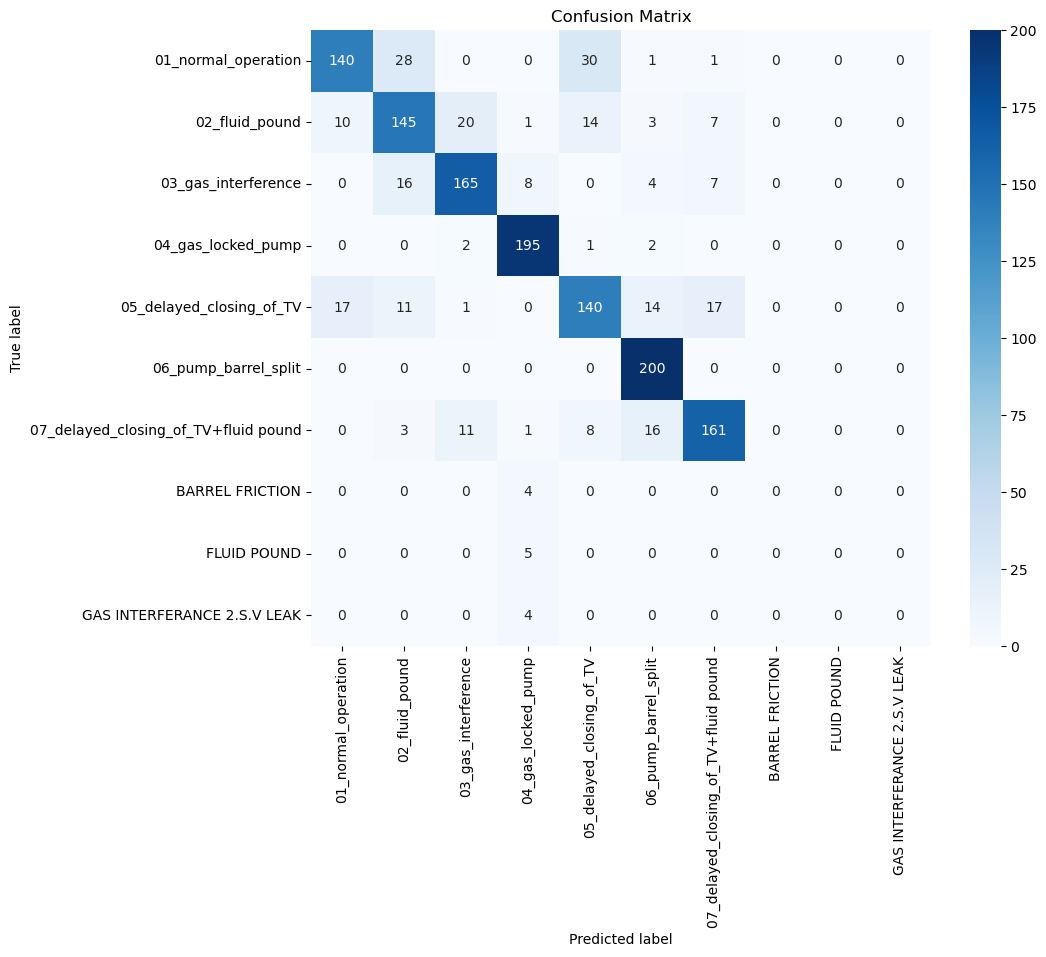

(0.8110403397027601,
 0.8024301535212587,
 0.8110403397027601,
 0.8044621804764267)

In [7]:
def evaluate_model(model, test_loader, criterion, device, class_names):

    model.eval()
    test_loss = 0.0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    test_loss /= len(test_loader)
    accuracy = accuracy_score(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predicted, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predicted, average='weighted', zero_division=0)

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

    # رسم مصفوفة الالتباس
    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

evaluate_model(model, test_loader, criterion, device, class_names)